# Playing with TrueFX data and JuliaDB

This is an example workflow for loading, working with and saving datasets in Julia. There are a few packages for working with data, JuliaDB developed by JuliaComputing is one of them.

Other popular alternatives are:

- DataFrames.jl
- Query.jl
- TypedTables.jl

In [1]:
using Distributed
addprocs(20)
nworkers()

20

In [2]:
using JuliaDB

## TrueFX dataset

The dataset we will explore in this notebook contains currency conversion buy and offer prices at millisecond resolution. We have data from 2009 to 2016. The raw CSV files size up to 260GB, there are 1305 of them.

In [3]:
csvfiles = glob("indata/*-2016-*.csv")

180-element Array{String,1}:
 "indata/AUDJPY-2016-01.csv"
 "indata/AUDJPY-2016-02.csv"
 "indata/AUDJPY-2016-03.csv"
 "indata/AUDJPY-2016-04.csv"
 "indata/AUDJPY-2016-05.csv"
 "indata/AUDJPY-2016-06.csv"
 "indata/AUDJPY-2016-07.csv"
 "indata/AUDJPY-2016-08.csv"
 "indata/AUDJPY-2016-09.csv"
 "indata/AUDJPY-2016-10.csv"
 "indata/AUDJPY-2016-11.csv"
 "indata/AUDJPY-2016-12.csv"
 "indata/AUDNZD-2016-01.csv"
 ⋮                          
 "indata/USDJPY-2016-01.csv"
 "indata/USDJPY-2016-02.csv"
 "indata/USDJPY-2016-03.csv"
 "indata/USDJPY-2016-04.csv"
 "indata/USDJPY-2016-05.csv"
 "indata/USDJPY-2016-06.csv"
 "indata/USDJPY-2016-07.csv"
 "indata/USDJPY-2016-08.csv"
 "indata/USDJPY-2016-09.csv"
 "indata/USDJPY-2016-10.csv"
 "indata/USDJPY-2016-11.csv"
 "indata/USDJPY-2016-12.csv"

In [4]:
sum(filesize, csvfiles) / 1024^3  # size in GB

73.97284228075296

Let's take a peek at one of the files.

In [5]:
;head $(csvfiles[1])

AUD/JPY,20160104 00:00:00.108,87.641,87.651
AUD/JPY,20160104 00:00:00.154,87.640,87.651
AUD/JPY,20160104 00:00:00.922,87.640,87.650
AUD/JPY,20160104 00:00:01.185,87.640,87.651
AUD/JPY,20160104 00:00:01.311,87.641,87.651
AUD/JPY,20160104 00:00:01.472,87.641,87.653
AUD/JPY,20160104 00:00:01.527,87.640,87.653
AUD/JPY,20160104 00:00:01.529,87.641,87.653
AUD/JPY,20160104 00:00:01.740,87.641,87.651
AUD/JPY,20160104 00:00:01.755,87.640,87.651


The first step to using JuliaDB is to ingest the data into it. This is done by the `ingest` function. We have worked hard on speeding up CSV reading performance as much as possible. In many benchmarks our CSV parser can run 1.5-2 times faster than `pandas`.

In [6]:
using Dates

@time loadndsparse(csvfiles, output="bindata/full-2016",
    header_exists=false,
    chunks=80,
    colparsers=Dict(2=>dateformat"yyyymmdd HH:MM:SS.s", 3=>Float32, 4=>Float32),
    colnames=["pair", "timestamp", "bid", "ask"],
    indexcols=[1,2], datacols=[3,4])

120.742515 seconds (29.39 M allocations: 1.427 GiB, 0.79% gc time)


2-d Distributed NDSparse with 1671681959 values (2 field named tuples) in 80 chunks:
pair       timestamp               │ bid     ask
───────────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00.108 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:00.154 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:00.922 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:01.185 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:01.311 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.472 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.527 │ 87.64   87.653
"AUD/JPY"  2016-01-04T00:00:01.529 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.74  │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.755 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.167 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:03.26  │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.334 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:03.385 │ 87.641  87.65
"AUD/JPY"  2016-01-04T00:00:03.488 │ 87.64   87.648
"AUD/JPY"  2016-01-04T00:00:04.365 │ 

Once ingested, loading the data back is instantaneous. The data is "memory-mapped" to reduce IO bottlenecks.

In [7]:
@time data = load("bindata/full-2016")

  0.078831 seconds (129.82 k allocations: 6.334 MiB)


2-d Distributed NDSparse with 1671681959 values (2 field named tuples) in 80 chunks:
pair       timestamp               │ bid     ask
───────────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00.108 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:00.154 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:00.922 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:01.185 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:01.311 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.472 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.527 │ 87.64   87.653
"AUD/JPY"  2016-01-04T00:00:01.529 │ 87.641  87.653
"AUD/JPY"  2016-01-04T00:00:01.74  │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:01.755 │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.167 │ 87.641  87.651
"AUD/JPY"  2016-01-04T00:00:03.26  │ 87.64   87.651
"AUD/JPY"  2016-01-04T00:00:03.334 │ 87.64   87.65
"AUD/JPY"  2016-01-04T00:00:03.385 │ 87.641  87.65
"AUD/JPY"  2016-01-04T00:00:03.488 │ 87.64   87.648
"AUD/JPY"  2016-01-04T00:00:04.365 │ 

# Range queries

Data in JuliaDB's DTable is indexed by many dimensions. This allows us to do highly efficient range queries

In [8]:
@time subset1 = data[["EUR/JPY", "USD/JPY"], DateTime("2016-02-01"):Dates.Millisecond(1):DateTime("2016-05-31")] 

  0.326333 seconds (822.83 k allocations: 39.949 MiB, 6.55% gc time)


2-d Distributed NDSparse of (2 field named tuples) in 80 chunks:
pair       timestamp               │ bid      ask
───────────────────────────────────┼─────────────────
"EUR/JPY"  2016-02-01T00:00:00.031 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.085 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.186 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.289 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.349 │ 131.366  131.377
"EUR/JPY"  2016-02-01T00:00:00.789 │ 131.365  131.377
"EUR/JPY"  2016-02-01T00:00:00.821 │ 131.365  131.378
"EUR/JPY"  2016-02-01T00:00:00.853 │ 131.367  131.378
"EUR/JPY"  2016-02-01T00:00:00.96  │ 131.368  131.378
"EUR/JPY"  2016-02-01T00:00:01.07  │ 131.37   131.378
"EUR/JPY"  2016-02-01T00:00:01.095 │ 131.37   131.379
"EUR/JPY"  2016-02-01T00:00:01.138 │ 131.37   131.38
"EUR/JPY"  2016-02-01T00:00:01.333 │ 131.372  131.384
"EUR/JPY"  2016-02-01T00:00:01.338 │ 131.37   131.384
"EUR/JPY"  2016-02-01T00:00:01.389 │ 131.372  131.384
"EUR/JPY"  2016-02-01T

In [9]:
typeof(subset1)

JuliaDB.DNDSparse{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}},NamedTuple{(:bid, :ask),Tuple{Float32,Float32}}}

In [10]:
subset1.chunks

80-element Array{Dagger.Thunk,1}:
 *240*
 *241*
 *242*
 *243*
 *244*
 *245*
 *246*
 *247*
 *248*
 *249*
 *250*
 *251*
 *252*
 ⋮    
 *308*
 *309*
 *310*
 *311*
 *312*
 *313*
 *314*
 *315*
 *316*
 *317*
 *318*
 *319*

In [11]:
a = subset1.domains[1]

JuliaDB.IndexSpace{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}}}((pair = "AUD/JPY", timestamp = 2016-01-04T00:00:00.108)..(pair = "AUD/JPY", timestamp = 2016-02-29T23:59:52.885), (pair = "AUD/JPY", timestamp = 2016-01-04T00:00:00.108)..(pair = "AUD/JPY", timestamp = 2016-02-29T23:59:52.885), Nullable{Int64}())

In [12]:
subset1.domains[1].interval

(pair = "AUD/JPY", timestamp = 2016-01-04T00:00:00.108)..(pair = "AUD/JPY", timestamp = 2016-02-29T23:59:52.885)

In [13]:
subset1.domains[1].boundingrect

(pair = "AUD/JPY", timestamp = 2016-01-04T00:00:00.108)..(pair = "AUD/JPY", timestamp = 2016-02-29T23:59:52.885)

In [14]:
subset1.domains[1].nrows

Nullable{Int64}()

In [15]:
NDSparse |> methods

# 3 methods for generic function "(::Type)":
[1] (::Type{NDSparse})(idx::Columns, data; kwargs...) in IndexedTables at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:220
[2] (::Type{NDSparse})(x; kwargs...) in IndexedTables at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/tabletraits.jl:51
[3] (::Type{NDSparse})(columns...; names, rest...) in IndexedTables at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:284

In [17]:
@time subset2 = data[["EUR/JPY", "USD/JPY"], DateTime("2016-02-01"):Dates.Millisecond(1):DateTime("2016-05-31")] |> compute

 19.620846 seconds (2.37 M allocations: 121.356 MiB, 0.37% gc time)


2-d Distributed NDSparse with 66822797 values (2 field named tuples) in 4 chunks:
pair       timestamp               │ bid      ask
───────────────────────────────────┼─────────────────
"EUR/JPY"  2016-02-01T00:00:00.031 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.085 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.186 │ 131.362  131.377
"EUR/JPY"  2016-02-01T00:00:00.289 │ 131.364  131.377
"EUR/JPY"  2016-02-01T00:00:00.349 │ 131.366  131.377
"EUR/JPY"  2016-02-01T00:00:00.789 │ 131.365  131.377
"EUR/JPY"  2016-02-01T00:00:00.821 │ 131.365  131.378
"EUR/JPY"  2016-02-01T00:00:00.853 │ 131.367  131.378
"EUR/JPY"  2016-02-01T00:00:00.96  │ 131.368  131.378
"EUR/JPY"  2016-02-01T00:00:01.07  │ 131.37   131.378
"EUR/JPY"  2016-02-01T00:00:01.095 │ 131.37   131.379
"EUR/JPY"  2016-02-01T00:00:01.138 │ 131.37   131.38
"EUR/JPY"  2016-02-01T00:00:01.333 │ 131.372  131.384
"EUR/JPY"  2016-02-01T00:00:01.338 │ 131.37   131.384
"EUR/JPY"  2016-02-01T00:00:01.389 │ 131.372  131.384
"EUR/

In [18]:
typeof(subset2)

JuliaDB.DNDSparse{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}},NamedTuple{(:bid, :ask),Tuple{Float32,Float32}}}

In [19]:
subset2.chunks

4-element Array{Dagger.Chunk{Any,MemPool.DRef},1}:
 Dagger.Chunk{Any,MemPool.DRef}(NDSparse{NamedTuple{(:bid, :ask),Tuple{Float32,Float32}},Tuple{String,DateTime},Columns{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}},NamedTuple{(:pair, :timestamp),Tuple{WeakRefStrings.StringArray{String,1},Array{DateTime,1}}}},Columns{NamedTuple{(:bid, :ask),Tuple{Float32,Float32}},NamedTuple{(:bid, :ask),Tuple{Array{Float32,1},Array{Float32,1}}}}}, JuliaDB.IndexSpace{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}}}((pair = "EUR/JPY", timestamp = 2016-02-01T00:00:00.031)..(pair = "EUR/JPY", timestamp = 2016-04-29T20:59:59.895), (pair = "EUR/JPY", timestamp = 2016-02-01T00:00:00.031)..(pair = "EUR/JPY", timestamp = 2016-04-29T20:59:59.895), Nullable{Int64}(23434479)), MemPool.DRef(2, 122, 0x0000000030e35cad), true)
 Dagger.Chunk{Any,MemPool.DRef}(NDSparse{NamedTuple{(:bid, :ask),Tuple{Float32,Float32}},Tuple{String,DateTime},Columns{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}},

In [20]:
subset2.domains

4-element Array{JuliaDB.IndexSpace{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}}},1}:
 JuliaDB.IndexSpace{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}}}((pair = "EUR/JPY", timestamp = 2016-02-01T00:00:00.031)..(pair = "EUR/JPY", timestamp = 2016-04-29T20:59:59.895), (pair = "EUR/JPY", timestamp = 2016-02-01T00:00:00.031)..(pair = "EUR/JPY", timestamp = 2016-04-29T20:59:59.895), Nullable{Int64}(23434479))
 JuliaDB.IndexSpace{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}}}((pair = "EUR/JPY", timestamp = 2016-05-02T00:00:00.033)..(pair = "EUR/JPY", timestamp = 2016-05-30T23:59:59.834), (pair = "EUR/JPY", timestamp = 2016-05-02T00:00:00.033)..(pair = "EUR/JPY", timestamp = 2016-05-30T23:59:59.834), Nullable{Int64}(12669244))
 JuliaDB.IndexSpace{NamedTuple{(:pair, :timestamp),Tuple{String,DateTime}}}((pair = "USD/JPY", timestamp = 2016-02-01T00:00:00.02)..(pair = "USD/JPY", timestamp = 2016-03-31T23:59:59.989), (pair = "USD/JPY", timestamp = 2016-02-01T00:00:00.02)

# Filtering

User defined functions are fast!

In [45]:
@everywhere using Dates
@everywhere isusd(pair)   = occursin(pair, "USD")
@everywhere isweekday(dt) = 1 <= Dates.day(dt) <= 5

In [50]:
@time weekdayusd = filter((:pair => isusd, :timestamp => isweekday),
                          data) |> compute

ArgumentError: ArgumentError: invalid index: Union{}[] of type Array{Union{},1}

# Aggregation

Below we calculate an hourly window for the data from 2016. We will get the maximum bid price and the minimum offer price for each stock in the hour.

In [23]:
@everywhere fiveminutes(t) = floor(t, Dates.Minute(5))

In [24]:
@time fiveminute_data = groupreduce((bid=:bid=>max, ask=:ask=>min), 
                                    data, 
                                    (:pair, :timestamp => fiveminutes))

153.801833 seconds (3.82 M allocations: 194.391 MiB, 0.09% gc time)


2-d Distributed NDSparse with 1096697 values (2 field named tuples) in 80 chunks:
pair       timestamp           │ bid     ask
───────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00 │ 87.656  87.63
"AUD/JPY"  2016-01-04T00:05:00 │ 87.662  87.636
"AUD/JPY"  2016-01-04T00:10:00 │ 87.688  87.642
"AUD/JPY"  2016-01-04T00:15:00 │ 87.691  87.665
"AUD/JPY"  2016-01-04T00:20:00 │ 87.706  87.681
"AUD/JPY"  2016-01-04T00:25:00 │ 87.713  87.683
"AUD/JPY"  2016-01-04T00:30:00 │ 87.715  87.674
"AUD/JPY"  2016-01-04T00:35:00 │ 87.683  87.621
"AUD/JPY"  2016-01-04T00:40:00 │ 87.612  87.576
"AUD/JPY"  2016-01-04T00:45:00 │ 87.618  87.579
"AUD/JPY"  2016-01-04T00:50:00 │ 87.6    87.537
"AUD/JPY"  2016-01-04T00:55:00 │ 87.593  87.564
"AUD/JPY"  2016-01-04T01:00:00 │ 87.602  87.401
"AUD/JPY"  2016-01-04T01:05:00 │ 87.477  87.38
"AUD/JPY"  2016-01-04T01:10:00 │ 87.375  87.213
"AUD/JPY"  2016-01-04T01:15:00 │ 87.263  86.981
"AUD/JPY"  2016-01-04T01:20:00 │ 87.135  87.01
"AUD/JPY"  2

### Saving intermediate data

As an aside, you can save any interesting intermediate data you want to load later.

In [25]:
@time save(fiveminute_data, "bindata/fiveminute-2016")

  0.436822 seconds (738.10 k allocations: 36.935 MiB, 4.03% gc time)


2-d Distributed NDSparse with 1096697 values (2 field named tuples) in 80 chunks:
pair       timestamp           │ bid     ask
───────────────────────────────┼───────────────
"AUD/JPY"  2016-01-04T00:00:00 │ 87.656  87.63
"AUD/JPY"  2016-01-04T00:05:00 │ 87.662  87.636
"AUD/JPY"  2016-01-04T00:10:00 │ 87.688  87.642
"AUD/JPY"  2016-01-04T00:15:00 │ 87.691  87.665
"AUD/JPY"  2016-01-04T00:20:00 │ 87.706  87.681
"AUD/JPY"  2016-01-04T00:25:00 │ 87.713  87.683
"AUD/JPY"  2016-01-04T00:30:00 │ 87.715  87.674
"AUD/JPY"  2016-01-04T00:35:00 │ 87.683  87.621
"AUD/JPY"  2016-01-04T00:40:00 │ 87.612  87.576
"AUD/JPY"  2016-01-04T00:45:00 │ 87.618  87.579
"AUD/JPY"  2016-01-04T00:50:00 │ 87.6    87.537
"AUD/JPY"  2016-01-04T00:55:00 │ 87.593  87.564
"AUD/JPY"  2016-01-04T01:00:00 │ 87.602  87.401
"AUD/JPY"  2016-01-04T01:05:00 │ 87.477  87.38
"AUD/JPY"  2016-01-04T01:10:00 │ 87.375  87.213
"AUD/JPY"  2016-01-04T01:15:00 │ 87.263  86.981
"AUD/JPY"  2016-01-04T01:20:00 │ 87.135  87.01
"AUD/JPY"  2

# Lazy operations and Views

Operations on DTable are lazy. Data only gets computed when it's required or explicitly requested using `compute` or `gather` functions.

This allows some interesting things:

- One can set up a pipeline of opearations and fuse them so that there's no need to write intermediate results or read data more than once
- This is also the mechanism that makes JuliaDB out-of-core. You can run it even when your data will not fit in main memory
- Sometimes you might be interested in only a part of the output of a sequence of operations, but find it convenient to write the sequence of operations once and then query parts of the final result.

## Interactive views into query results:

In [26]:
using Interact
using Plots
gr()

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/666570235a8c6e99bbd2f3cbdb5ee0990bcb4434-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/666570235a8c6e99bbd2f3cbdb5ee0990bcb4434-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Plots.GRBackend()

In [27]:
current_data = @manipulate for 
        month  = [1:12;],
        window = Pair["hourly" => Dates.Hour(1), "5 minutes" => Dates.Minute(5)]
    
    date_range = DateTime(2016, month):Dates.Millisecond(1):DateTime(2016,month)+Dates.Month(1)-Dates.Millisecond(1)
    subdata = data[["EUR/GBP", "EUR/USD", "GBP/USD"], date_range]
    
    collect(groupreduce((bid=:bid=>min, ask=:ask=>max), 
            subdata, 
            (:pair, :timestamp => dt -> floor(dt, window))))
end

RemoteException: On worker 2:
MethodError: Cannot `convert` an object of type Array{Union{},1} to an object of type NDSparse
Closest candidates are:
  convert(::Type{NDSparse}, ::AbstractArray{T,N} where N) where T at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:515 got unsupported keyword arguments "presorted", "copy"
  convert(::Type{NDSparse}, ::Any, !Matched::Any; kwargs...) at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:423
  convert(::Type{NDSparse}, !Matched::Columns{#s74,C} where C<:Union{Tuple, Pair, NamedTuple} where #s74<:Pair; kwargs...) at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:424
  ...
#groupreduce#210 at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/reduce.jl:251
groupreduce at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/reduce.jl:228
groupchunk at /home/simonbyrne/.julia/packages/JuliaDB/vRAcT/src/reduce.jl:50
do_task at /home/simonbyrne/.julia/packages/Dagger/S6Typ/src/scheduler.jl:255
#112 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:269
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:56
macro expansion at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:269 [inlined]
#111 at ./task.jl:259

In [28]:
@manipulate for 
        month=[1:12;],
        window = Pair["hourly" => Dates.Hour(1), "5 minutes" => Dates.Minute(5)]
        
    pairs = ["EUR/GBP", "EUR/USD", "GBP/USD"]
    date_range = DateTime(2016, month):Dates.Millisecond(1):DateTime(2016,month)+Dates.Month(1)-Dates.Millisecond(1)
    p = Plots.Plot()
    for pair in pairs
        subdata = data[pair, date_range]
        result = collect(groupreduce((bid=:bid=>min, ask=:ask=>max), 
            subdata, :timestamp => dt -> floor(dt, window)))

        plot!(p, keys(result, :timestamp), 
                values(result, :bid), fillrange=values(result, :ask), 
                label=pair, legend=:bottomleft)
    end
    p
end
# Check out June

RemoteException: On worker 2:
MethodError: Cannot `convert` an object of type Array{Union{},1} to an object of type NDSparse
Closest candidates are:
  convert(::Type{NDSparse}, ::AbstractArray{T,N} where N) where T at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:515 got unsupported keyword arguments "presorted", "copy"
  convert(::Type{NDSparse}, ::Any, !Matched::Any; kwargs...) at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:423
  convert(::Type{NDSparse}, !Matched::Columns{#s74,C} where C<:Union{Tuple, Pair, NamedTuple} where #s74<:Pair; kwargs...) at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/ndsparse.jl:424
  ...
#groupreduce#210 at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/reduce.jl:251
groupreduce at /home/simonbyrne/.julia/packages/IndexedTables/Jw0SP/src/reduce.jl:228
groupchunk at /home/simonbyrne/.julia/packages/JuliaDB/vRAcT/src/reduce.jl:50
do_task at /home/simonbyrne/.julia/packages/Dagger/S6Typ/src/scheduler.jl:255
#112 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:269
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:56
macro expansion at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:269 [inlined]
#111 at ./task.jl:259

# Vectorized Aggregation & Summary Statistics


For non-reduction operations, we can use `groupby`:

In [29]:
@time groupby(mean, fiveminute_data, (:pair,:timestamp=>Date), select=:bid)

UndefVarError: UndefVarError: mean not defined

In [30]:
# Can compute multiple in 1 go
@everywhere begin
    p25(x) = quantile(x,0.25f0)
    p50(x) = quantile(x,0.50f0)
    p75(x) = quantile(x,0.75f0)
end
stats = (mean, std, var, p25, p50, p75)
@time groupby(stats, fiveminute_data, (:pair,:timestamp=>Date), select=:bid)

UndefVarError: UndefVarError: mean not defined

JuliaDB incorporates support for OnlineStats.jl, a library for computing fast statistics using streaming data:

In [31]:
using OnlineStats

In [32]:
@time groupreduce(Mean(), fiveminute_data, (:pair,:timestamp=>Date); select = :bid)

  2.981500 seconds (2.76 M allocations: 139.363 MiB, 3.49% gc time)


2-d Distributed NDSparse with 3898 values (Mean{EqualWeight}) in 80 chunks:
pair       timestamp  │
──────────────────────┼────────────────────────────
"AUD/JPY"  2016-01-04 │ Mean: n=288 | value=86.0211
"AUD/JPY"  2016-01-05 │ Mean: n=288 | value=85.5445
"AUD/JPY"  2016-01-06 │ Mean: n=288 | value=84.1173
"AUD/JPY"  2016-01-07 │ Mean: n=288 | value=82.8144
"AUD/JPY"  2016-01-08 │ Mean: n=264 | value=82.8973
"AUD/JPY"  2016-01-11 │ Mean: n=288 | value=82.1244
"AUD/JPY"  2016-01-12 │ Mean: n=288 | value=82.2125
"AUD/JPY"  2016-01-13 │ Mean: n=288 | value=82.7428
"AUD/JPY"  2016-01-14 │ Mean: n=288 | value=82.0008
"AUD/JPY"  2016-01-15 │ Mean: n=252 | value=81.1253
"AUD/JPY"  2016-01-18 │ Mean: n=288 | value=80.7458
"AUD/JPY"  2016-01-19 │ Mean: n=288 | value=81.3649
"AUD/JPY"  2016-01-20 │ Mean: n=288 | value=80.3517
"AUD/JPY"  2016-01-21 │ Mean: n=288 | value=81.4381
"AUD/JPY"  2016-01-22 │ Mean: n=252 | value=82.9526
"AUD/JPY"  2016-01-25 │ Mean: n=288 | value=82.8088
"AUD/JPY"  2016-

Can compute multiple statistics in one go using `Series`:

In [33]:
@time sumdata = groupreduce(Series(Mean(),Variance(),Quantile()), fiveminute_data, (:pair,:timestamp=>Date); select = :bid)

  2.564360 seconds (1.65 M allocations: 81.192 MiB, 1.91% gc time)


2-d Distributed NDSparse with 3898 values (Series{Number,Tuple{Mean{EqualWeight},Variance{EqualWeight},Quantile{OMAS,LearningRate}}}) in 80 chunks:
    Dimensions#  colname    type
────────────────────
1  pair       String
2  timestamp  Date
    ValuesSeries{Number,Tuple{Mean{EqualWeight},Variance{EqualWeight},Quantile{OMAS,LearningRate}}}

In [34]:
map(value,sumdata)

2-d Distributed NDSparse with 3898 values (3-tuples) in 80 chunks:
pair       timestamp  │ 3        4          5
──────────────────────┼────────────────────────────────────────────────
"AUD/JPY"  2016-01-04 │ 86.0211  0.276272   [85.6905, 85.7363, 85.7449]
"AUD/JPY"  2016-01-05 │ 85.5445  0.176196   [85.1153, 85.1804, 85.2797]
"AUD/JPY"  2016-01-06 │ 84.1173  0.200841   [83.7674, 83.7703, 83.9226]
"AUD/JPY"  2016-01-07 │ 82.8144  0.2038     [82.4194, 82.528, 82.7617]
"AUD/JPY"  2016-01-08 │ 82.8973  0.310002   [82.1408, 82.1944, 82.5307]
"AUD/JPY"  2016-01-11 │ 82.1244  0.151321   [82.0387, 82.4543, 82.3808]
"AUD/JPY"  2016-01-12 │ 82.2125  0.0588263  [82.1935, 82.2629, 82.3317]
"AUD/JPY"  2016-01-13 │ 82.7428  0.24151    [82.408, 82.1441, 82.6577]
"AUD/JPY"  2016-01-14 │ 82.0008  0.18632    [82.2234, 82.5035, 82.5395]
"AUD/JPY"  2016-01-15 │ 81.1253  0.675523   [80.3092, 80.5146, 80.4131]
"AUD/JPY"  2016-01-18 │ 80.7458  0.0420077  [80.6123, 80.5673, 80.6666]
"AUD/JPY"  2016-01-19 │ 8

In [35]:
@time sumdata_all = groupreduce(Series(Mean(),Variance(),Quantile()), data, (:pair,:timestamp=>Date); select = :bid)

214.697251 seconds (274.78 k allocations: 14.368 MiB)


2-d Distributed NDSparse with 3898 values (Series{Number,Tuple{Mean{EqualWeight},Variance{EqualWeight},Quantile{OMAS,LearningRate}}}) in 80 chunks:
    Dimensions#  colname    type
────────────────────
1  pair       String
2  timestamp  Date
    ValuesSeries{Number,Tuple{Mean{EqualWeight},Variance{EqualWeight},Quantile{OMAS,LearningRate}}}

# Arbitrage using JuMP

An important advantage of JuliaDB over other time-series databases is that it lets you leverage the whole ecosystem of Julia packages. This composability is very powerful. Here's an example where we apply the state-of-the-art JuMP linear programming library on our data to determine arbitrage.


This example [example](http://mattmcd.github.io/2013/03/30/FX-Arbitrage-CLP.html) is taken from ["Optimization in Finance" by Cornuejols and Tutuncu](https://www.amazon.co.uk/Optimization-Methods-Finance-Mathematics-Risk/dp/0521861705)

In [36]:
using JuMP, GLPK, GLPKMathProgInterface

Below is our constraint programming function. Given currency conversion rates of 6 pairs of currencies, it will return the amount of currency to transact for each possible conversion. The objective is to make $100 in every five minute window!

In [37]:
@everywhere function fx_arbitrage(eurusd, eurgbp, eurjpy, gbpusd, gbpjpy, usdjpy)

    usdeur = 1.0/eurusd
    usdgbp = 1.0/gbpusd
    gbpeur = 1.0/eurgbp
    jpyusd = 1.0/usdjpy
    jpyeur = 1.0/eurjpy
    jpygbp = 1.0/gbpjpy

    m = JuMP.Model(solver = GLPKMathProgInterface.GLPKSolverLP(msg_lev = GLPK.MSG_ERR))

    JuMP.@variables m begin
        de; dp; dy; ed; ep; ey; pd; pe; py; yd; ye; yp; profit
    end

    JuMP.@objective(m, Max, profit)

    JuMP.@constraints(m, begin
        0 <= de <= 100
        0 <= dp <= 100
        0 <= dy <= 100
        0 <= ed <= 100
        0 <= ep <= 100
        0 <= ey <= 100
        0 <= pd <= 100
        0 <= pe <= 100
        0 <= py <= 100
        0 <= yd <= 100
        0 <= ye <= 100
        0 <= yp <= 100
        de + dp + dy - eurusd*ed - gbpusd*pd - jpyusd*yd == profit
        ed + ep + ey - usdeur*de - gbpeur*pe - jpyeur*ye == 0.0
        pd + pe + py - usdgbp*dp - eurgbp*ep - jpygbp*yp == 0.0
        yd + ye + yp - usdjpy*dy - eurjpy*ey - gbpjpy*py == 0.0
    end)

    JuMP.solve(m)

    JuMP.getvalue(profit)
end

CompositeException: On worker 2:
LoadError: UndefVarError: JuMP not defined
top-level scope
eval at ./boot.jl:319
#116 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:276
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:56
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/process_messages.jl:65
#102 at ./task.jl:259
in expression starting at In[37]:12
#remotecall_wait#154(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Function, ::Distributed.Worker, ::Module, ::Vararg{Any,N} where N) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:421
remotecall_wait(::Function, ::Distributed.Worker, ::Module, ::Vararg{Any,N} where N) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:412
#remotecall_wait#157(::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::Function, ::Int64, ::Module, ::Vararg{Any,N} where N) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:433
remotecall_wait(::Function, ::Int64, ::Module, ::Vararg{Any,N} where N) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.0/Distributed/src/remotecall.jl:433
(::getfield(Distributed, Symbol("##163#165")){Module,Expr})() at ./task.jl:259

...and 19 more exception(s).


We can take out columns from a Distributed table, and the column itself will be a distributed array.

In [38]:
getbids(t) = values(t, :bid)
bidscol = getbids(fiveminute_data)

Dagger.DArray{Float32,1,typeof(JuliaDB.dvcat)}(1096697,)

In [39]:
length(chunks(bidscol)) # same number of chunks as the data! Again this is a lazy view.

80

In [40]:
@time sum(bidscol) # just for kicks

  0.604916 seconds (904.10 k allocations: 46.732 MiB, 3.82% gc time)


4.817453f7

In [41]:
t_5m  = DateTime(2016,6,1):Dates.Minute(5):DateTime(2016,7,1)

# Arbitrage example
inds = keys(fiveminute_data["EUR/USD",t_5m], :timestamp) |> collect
eurusd = fiveminute_data["EUR/USD",t_5m] |> getbids
eurgbp = fiveminute_data["EUR/GBP",t_5m] |> getbids
eurjpy = fiveminute_data["EUR/JPY",t_5m] |> getbids
gbpusd = fiveminute_data["GBP/USD",t_5m] |> getbids
gbpjpy = fiveminute_data["GBP/JPY",t_5m] |> getbids
usdjpy = fiveminute_data["USD/JPY",t_5m] |> getbids

arbitrage_profit = map(fx_arbitrage, map(collect, (eurusd, eurgbp, eurjpy, gbpusd, gbpjpy, usdjpy))...)

6191-element Array{Float64,1}:
 0.0007537094654708199
 0.0023719235812080797
 0.014636902877654734 
 0.04926458678171741  
 0.01244578481502856  
 0.009105181805722395 
 0.04343290322292148  
 0.021099234984802706 
 0.011945250517257477 
 0.04280524992142887  
 0.006251190819199337 
 0.021894287231361886 
 0.04245281987874705  
 ⋮                    
 0.060281640386619983 
 0.014038058649191498 
 0.052395721417852315 
 0.01694989428276017  
 0.008551653148231253 
 0.034352540687393684 
 0.010181195398686782 
 0.022109103059761992 
 0.008401083373911433 
 0.11072383688284049  
 0.02369899521799823  
 0.046274358646059    

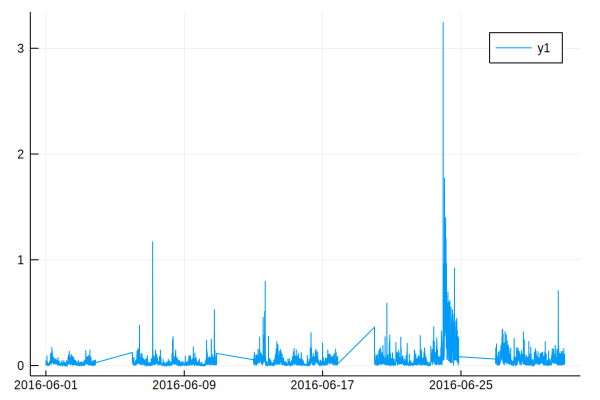

In [42]:
plot(inds, arbitrage_profit )